In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [4]:
format_plots()
#format_pizza_plots()

In [5]:
## update data
def filter_df(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
m_data = data.query('age < 95').copy()
#m_data = data.copy()

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
f_data = data.query('age < 95').copy()
#f_data = data.copy()

In [8]:
# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])
#data.set_index('sex',inplace=True,append=True)

In [9]:
# choose a model for decoder
# choose a model for decoder
#clf = svm.SVC(kernel='linear') 
clf = RandomForestClassifier(n_estimators = 200)
#clf = LinearRegression()
#clf = KNeighborsRegressor(n_neighbors=10)

# choose cross validation scheme
cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
#cv=5

#number of iterations for shuffle
it=10

100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]


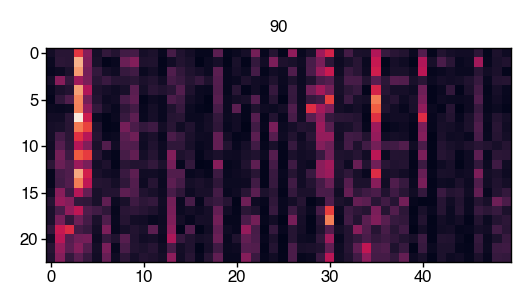

In [10]:
sh_ages=[]
age2=[]
acc=[]
sh_acc=[]
for age,_df in enumerate(data.groupby('age')):
    #ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    age2.append(_df[0])
    x = _df[1].to_numpy()
    #x = np.log(x + 1e-6)
    plt.imshow(x)
    plt.title(str(_df[0]))
    #plt.show()
    y=_df[1].index.get_level_values('sex')
    y_pred = cross_val_predict(clf, x, y, cv=cv)
    acc.append(np.mean(cross_val_score(clf, x, y, cv=cv)))
    for i in tqdm(range(it)):
        sh_ages.append(_df[0])
        ysh_temp=np.random.permutation(y)
        sh_acc.append(np.mean(cross_val_score(clf, x, ysh_temp, cv=cv)))

In [11]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

(array([-20.,   0.,  20.,  40.,  60.,  80., 100.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100')])

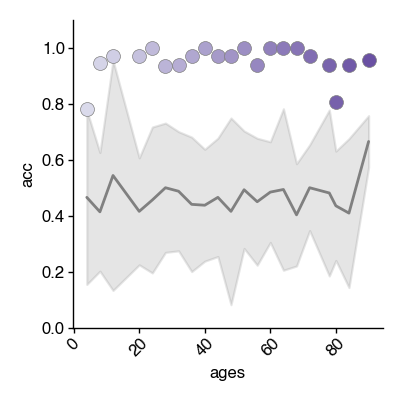

In [15]:
fig, ax = plt.subplots(figsize=(2, 2))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray', estimator='mean', errorbar=('sd', 2))
#sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              #dodge=0, 
#              join=False, 
#              ax=ax, 
#              scale=1,
#              hue='ages',
 #             palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
 #            )
#sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot (data=df, x='ages', y='acc', 
              markers=True, 
              marker='o',
              markersize=5,
              palette = cmm,
              hue='ages',
              linestyle='-',
              markeredgecolor='grey', 
              markeredgewidth=0.25,
             legend=False)
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
sns.despine()
plt.xticks(rotation=45)


In [16]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_sex_decoder_across_life.pdf', bbox_inches='tight')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, '4'),
  Text(1, 0, '8'),
  Text(2, 0, '12'),
  Text(3, 0, '20'),
  Text(4, 0, '24'),
  Text(5, 0, '28'),
  Text(6, 0, '32'),
  Text(7, 0, '36'),
  Text(8, 0, '40'),
  Text(9, 0, '44'),
  Text(10, 0, '48'),
  Text(11, 0, '52'),
  Text(12, 0, '56'),
  Text(13, 0, '60'),
  Text(14, 0, '64'),
  Text(15, 0, '68'),
  Text(16, 0, '72'),
  Text(17, 0, '78'),
  Text(18, 0, '80'),
  Text(19, 0, '84'),
  Text(20, 0, '90')])

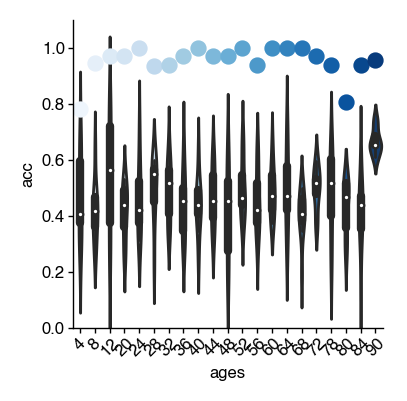

In [17]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, 
               #color='gray', 
               palette = 'Blues', 
               fill = False,
                inner_kws=dict(box_width=15, whis_width=2, color=".8"),
               #hue='ages',
              )
#sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray', estimator='mean', errorbar=('sd', 2))
sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              dodge=0, 
              join=False, 
              ax=ax, 
              scale=1,
              hue='ages',
             palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
            )

plt.ylim([0,1.1])
plt.legend([],[], frameon=False)
sns.despine()
plt.xticks(rotation=45)